In [1]:
import numpy as np
from tqdm.auto import tqdm
from functools import partial
import matplotlib.pyplot as plt

from commplax import util, comm
from gdbp import gdbp_base as gb, data as gdat, aux

/home/xiaoxinyu/.conda/envs/fiber/lib/python3.9/site-packages/flax/core/frozen_dict.py:169: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(
2024-03-19 02:12:26.254008: E external/org_tensorflow/tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [2]:
ds_train, ds_test = gdat.load(1, 0, 4, 1)[0], gdat.load(2, 0, 4, 1)[0]

loading data:   0%|          | 0/1 [00:00<?, ?it/s]

loading data:   0%|          | 0/1 [00:00<?, ?it/s]

In [78]:
# Note: see `https://github.com/remifan/gdbp_study/blob/master/gdbp/gdbp_base.py` for model definition

def init_models(data: gdat.Input, **kwargs):
  ''' make CDC and DBP's derivatives
      (all methods has trainable R-filter)
      cdc:  static D-filter, no NLC
      dbp:  static D-filter, scalar manually optimized NLC factor
      fdbp: static D-filter, static N-filter scaled by manually optimized NLC factor
      edbp: static D-filter, tap-by-tap optimizable/trainable N-filter
      gdbp: tap-by-tap optimizable/trainable D-filter and N-filter
  '''
  
  mode  = kwargs.get('mode', 'train')
  steps = kwargs.get('steps', 3)
  dtaps = kwargs.get('dtaps', 261)
  ntaps = kwargs.get('ntaps', 41)
  rtaps = kwargs.get('rtaps', 61)
  xi    = kwargs.get('xi', 1.1) # optimal xi for FDBP
  
  fdbp_init = partial(gb.fdbp_init, data.a, steps=steps)
  model_init = partial(gb.model_init, data)
  
  comm_conf = {'mode': mode, 'steps': steps, 'dtaps': dtaps, 'rtaps': rtaps} # common configurations
  #     init. func.| define model structure parameters and some initial values    | define static modules    | identifier
  cdc  = model_init({**comm_conf, 'ntaps': 1,     'init_fn': fdbp_init(xi=0.0)},  [('fdbp_0',)],             name='CDC')
  dbp  = model_init({**comm_conf, 'ntaps': 1,     'init_fn': fdbp_init(xi=0.15)}, [('fdbp_0',)],             name='DBP')
  fdbp = model_init({**comm_conf, 'ntaps': ntaps, 'init_fn': fdbp_init(xi=xi)},   [('fdbp_0',)],             name='FDBP')
  edbp = model_init({**comm_conf, 'ntaps': ntaps, 'init_fn': fdbp_init(xi=xi)},   [('fdbp_0', r'DConv_\d')], name='EDBP')
  gdbp = model_init({**comm_conf, 'ntaps': ntaps, 'init_fn': fdbp_init(xi=xi)},   [],                        name='GDBP')
  
  # return cdc, dbp, fdbp, edbp, gdbp
  return (cdc,)


models_train = init_models(ds_train)
models_test = init_models(ds_test, mode='test')

In [79]:
results = []
sigs = []

for model_train, model_test in tqdm(zip(models_train, models_test), total=1, desc='sweep models'):
  # use trained params of the 3rd last batch, as tailing samples are corrupted by CD
  params_queue = [None] * 3
  
  for _, p, _ in gb.train(model_train, ds_train, n_iter=2000):
    params_queue.append(p)
    params = params_queue.pop(0)

  metric,z = gb.test(model_test, params, ds_test, metric_fn=comm.qamqot_local)
  results.append(metric)
  sigs.append(z)

sweep models:   0%|          | 0/1 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

In [106]:
import jax
import pickle, torch
signal = jax.device_get(sigs[0].val)
truth = ds_test.x[sigs[0].t.start:sigs[0].t.stop]
pickle.dump((torch.tensor(signal[None,...]), torch.tensor(truth[None,...]), torch.tensor([[0, 0.0, 72e9, 7]])), open('data/lab/test_2_0_4_1.pkl', 'wb'))

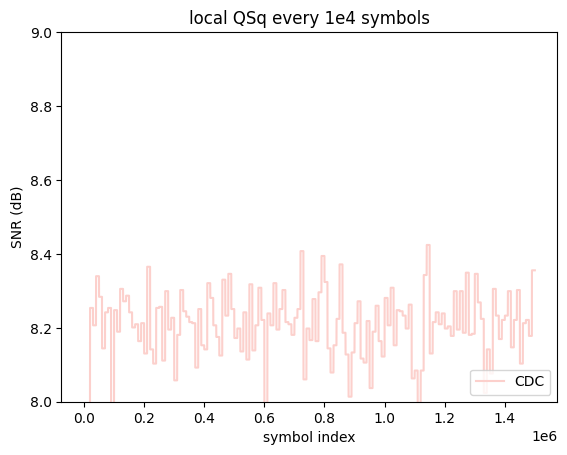

In [116]:
import matplotlib.pyplot as plt

labels = ['CDC', 'DBP', 'FDBP', 'EDBP', 'GDBP']
colors = plt.cm.RdPu(np.linspace(0.2, 0.8, len(labels)))

fig = plt.figure(dpi=100)
for r, l, c in zip(results, labels, colors):
  plt.plot(r['QSq'][:, 2], label=l, color=c) # averaged SNR of Pol. X and Pol. Y
plt.title('local QSq every 1e4 symbols')
plt.xlabel('symbol index')
plt.ylabel('SNR (dB)')
plt.ylim([8, 9])
plt.legend(loc='lower right')

In [66]:
s = 10000
np.mean(results[0]['QSq'][s:,2])

8.208386002609142

In [60]:
np.mean(results[1]['QSq'][s:,2])

8.351736015179613

In [61]:
np.mean(results[2]['QSq'][s:,2])

8.633906955473917

In [62]:
np.mean(results[3]['QSq'][s:,2])

8.701216058264674

In [63]:
np.mean(results[4]['QSq'][s:,2])

8.716584877947842